In [14]:
'''
Author: Wenren Zhou
Date: 2024-04-25 13:50:14
LastEditors: Do not edit
LastEditTime: 2024-07-09 17:38:00
FilePath: \2243dataprocessing\psg\PSG_data_extraction.py
'''
import mne
import pyedflib
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
# from .constants import PSG_PATH

plt.rcParams['figure.figsize']=(12, 6)

class PSGDataProcessor:
    def __init__(self, file_path):
        """
        Initialize the PSGDataProcessor class without loading data immediately.

        Args:
        file_path (str): Path to the PSG file.
        """
        self.file_path = file_path
        self.data = None
        # self.raw_data = None
        self.edf_file = None
        self.sampling_rate = None
        self.ch_names = None
        self.start_datetime = None
        self.end_datetime = None
    
    def load_data(self):
        """
        Load PSG data from an EDF file.
        """
        self.data = mne.io.read_raw_edf(self.file_path, preload=True)
        # self.raw_data = self.data.get_data(return_times=False)
        self.sampling_rate = self.data.info['sfreq']
        self.ch_names = self.data.ch_names
        self.start_datetime = self.get_datetime_from_info(self.data.info['meas_date'])
        self.end_datetime = self.start_datetime + timedelta(seconds=self.data.times[-1])
        # self.ch_indices = {channel_name: idx for idx, channel_name in enumerate(self.ch_names)}
        
        # Access loaded data attributes
        print(f"Sampling Rate: {self.sampling_rate}")
        print(f"Channel Names: {self.ch_names}")
        print(f"Start Datetime: {self.start_datetime}")
                
    def psg_plot(self):
        self.data.plot()
        
    # def get_channel_index(self, channel_name):
    #     """
    #     Get the index of a specific channel by its name.

    #     Args:
    #     channel_name (str): Name of the channel.

    #     Returns:
    #     int: Index of the channel, or -1 if not found.
    #     """
    #     if not self.ch_indices:
    #         raise ValueError("Data not loaded. Please load the data first.")
        
    #     index = self.ch_indices.get(channel_name)
    #     if index is None:
    #         raise ValueError(f"Channel '{channel_name}' not found.")
    #     print(f"Index of channel '{channel_name}': {index}")
    #     return index

    def retrieve_info(self, info_name = 'file'):
        """
        Print detailed information about the EDF file.

        Args:
        info_name (str): The type of information to retrieve. Options are 'file', 'label', and 'signal'.
        """
        try:
            self.edf_file = pyedflib.EdfReader(self.file_path)
        except Exception as e:
            print(f"Failed to read EDF file: {e}")
            return
            
        if info_name == 'label':
            PSGDataProcessor.print_label_and_freq(list(zip(self.edf_file.getSignalLabels(), self.edf_file.getSampleFrequencies())))
        elif info_name == 'signal':
            PSGDataProcessor.print_sig_headers(self.edf_file.getSignalHeaders())
        else:
            PSGDataProcessor.print_file_header(self.edf_file.getHeader())

        self.edf_file.close()

    @staticmethod
    def print_label_and_freq(sig_freq):
        """
        Print signal labels and their corresponding sampling frequencies.

        Args:
        sig_freq (list of tuples): List containing signal labels and frequencies.
        """
        print("Signal Labels | Sampling Frequencies")
        print("------------------------------------")
        for label, freq in sig_freq:
            print(f"{label} | {freq}")

    @staticmethod
    def print_sig_headers(signal_headers):
        """
        Print all headers for each signal.

        Args:
        signal_headers (list): List containing headers of each signal.
        """
        for i, header in enumerate(signal_headers):
            print(f"Signal {i+1}:")
            print("Field Name | Value")
            print("------------------")
            for field_name, value in header.items():
                print(f"{field_name} | {value}")
            print("\n")

    @staticmethod
    def print_file_header(file_header):
        """
        Print the main header of the EDF file.

        Args:
        file_header (dict): Header information of the EDF file.
        """
        print("Field Name | Value")
        print("------------------")
        for field_name, value in file_header.items():
            print(f"{field_name} | {value}")
    
    @staticmethod
    def get_datetime_from_info(meas_date):
        """
        Convert measurement date to datetime object, handling various formats.

        Args:
        meas_date (tuple or datetime): The measurement date from MNE info.

        Returns:
        datetime: A datetime object.
        """
        if isinstance(meas_date, tuple):
            return datetime.fromtimestamp(meas_date[0]).replace(tzinfo=None)
        return meas_date.replace(tzinfo=None)
    
    def convert_to_datetime(self, start_datetime, time_column):
        """
        Converts a list of pure time values in seconds to actual datetime values.

        Parameters:
        - start_datetime (datetime): The starting datetime.
        - time_column (list): A list of pure time values in seconds since the start_datetime.

        Returns:
        - list: A list of actual datetime values corresponding to each pure time value.
        """
        actual_time_list = [start_datetime + timedelta(seconds=time) for time in time_column]
        return actual_time_list

    def extract_data_by_range(self, tmin, tmax):
        """
        Extract data for a specified time range from the PSG data.

        Args:
        tmin (float): Start time in seconds.
        tmax (float): End time in seconds.

        Returns:
        pd.DataFrame: DataFrame containing the extracted data.
        """
        # Ensure data is loaded
        if self.data is None:
            raise ValueError("Data not loaded. Please load the data first.")
        
        start_time = self.start_datetime + timedelta(seconds=tmin)
        end_time = self.start_datetime + timedelta(seconds=tmax)

        # Extract data for the specified time range
        extract_data, times = self.data[:, self.data.time_as_index([tmin, tmax])[0]:self.data.time_as_index([tmin, tmax])[1]]
        
        # Create a DataFrame and transpose the data array to match the DataFrame structure (rows are samples, columns are channels)
        extracted_df = pd.DataFrame(data=extract_data.T, columns=self.data.ch_names)
        
        # Set the index to the times array for better time representation
        extracted_df.index = self.convert_to_datetime(self.start_datetime, times)
        extracted_df.index.name = 'Time'
        
        return start_time, end_time, extracted_df

    def extract_segment_by_timestamp(self, start_datetime, end_datetime, data_types):
        """
        Extract specific types of data within a specified time range defined by timestamps.
        
        Args:
        start_datetime (datetime): Start datetime object.
        end_datetime (datetime): End datetime object.
        data_types (list): List of data types to extract, e.g., ['ECG', 'EEG'].
        
        Returns:
        dict: Dictionary of extracted data arrays keyed by type.
        """
        start_idx = int((start_datetime - self.start_datetime).total_seconds() * self.sampling_rate)
        end_idx = int((end_datetime - self.start_datetime).total_seconds() * self.sampling_rate)
        
        return self.extract_data_indices(start_idx, end_idx, data_types)

    def extract_data_indices(self, start_idx, end_idx, data_types):
        """
        Extract specific types of data within a specified index range.
        
        Args:
        start_idx (int): Start index.
        end_idx (int): End index.
        data_types (list): List of data types to extract, e.g., ['ECG', 'EEG'].
        
        Returns:
        dict: Dictionary of extracted data arrays keyed by type.
        """
        extracted_data = {}
        time_array = np.array(self.data[data_types[0]][1])
        extracted_data['Time'] = time_array[start_idx:end_idx]
        print(len(extracted_data['Time']))
        print(self.start_datetime)
        extracted_data['Time'] = self.convert_to_datetime(self.start_datetime, extracted_data['Time'])
        
        for data_type in data_types:
            if data_type in self.ch_names:
                data_array = np.array(self.data[data_type][0][0])
                extracted_data[data_type] = data_array[start_idx:end_idx]
            else:
                raise ValueError(f"Data type {data_type} not found in the dataset.")
            
        # Convert extracted_data to a pandas DataFrame
        extracted_data_df = pd.DataFrame.from_dict(extracted_data)
        extracted_data_df.set_index('Time', inplace=True)
        return extracted_data_df

    def plot_data(self, data, data_type, sampling_rate):
        """
        Plot the ECG data using Matplotlib.
        
        Args:
        ecg_data (numpy.ndarray): The ECG data to plot.
        sampling_rate (int): The sampling rate of the data.
        """
        time_axis = np.linspace(0, len(data) / sampling_rate, len(data))
        plt.figure(figsize=(12, 6))
        plt.plot(time_axis, data, label=data_type)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'{data_type} Data Plot')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def compare_plot(self, data_dict, channel_names, sampling_rate):
        """
        Plot multiple channels data for comparison using subplots.

        Args:
        data_dict (dict): Dictionary containing data arrays for channels.
        channel_names (list of str): List of channel names to plot.
        sampling_rate (int): The sampling rate of the data.
        """
        num_channels = len(channel_names)
        plt.figure(figsize=(12, 6 * num_channels))
        
        for i, channel in enumerate(channel_names):
            if channel in data_dict:
                ax = plt.subplot(num_channels, 1, i + 1)
                time_axis = np.linspace(0, len(data_dict[channel]) / sampling_rate, len(data_dict[channel]))
                ax.plot(time_axis, data_dict[channel], label=channel)
                ax.set_xlabel('Time (seconds)')
                ax.set_ylabel('Amplitude')
                ax.set_title(f'{channel} Data Plot')
                ax.legend()
                ax.grid(True)
            else:
                print(f"Data for {channel} not found in the provided data dictionary.")

        plt.tight_layout()
        plt.show()

    def ecg_diagram(self, ecg_slice):
        """
        Process and visualize an ECG signal slice with R-peaks.

        Args:
        ecg_slice (np.array): The slice of ECG data to process.
        """
        # Automatically process the (raw) ECG signal
        ecg_signals, ecg_info = nk.ecg_process(ecg_slice, sampling_rate=self.sampling_rate)

        # Plot the processed ECG signal
        nk.ecg_plot(ecg_signals, ecg_info)

        # Extract clean ECG and R-peaks location
        rpeaks = ecg_info["ECG_R_Peaks"]
        cleaned_ecg = ecg_signals["ECG_Clean"]

        # Visualize R-peaks in ECG signal
        plot = nk.events_plot(rpeaks, cleaned_ecg)
        plt.show()
        
        return ecg_signals, ecg_info
        
    def rsp_diagram(self, rsp_slice):
        """
        Process and visualize a respiratory signal slice with peaks.

        Args:
        rsp_slice (np.array): The slice of RSP data to process.
        """
        # Process the respiratory signal
        rsp_signals, rsp_info = nk.rsp_process(rsp_slice, sampling_rate=self.sampling_rate, report="text")

        # Plot the processed RSP signal
        nk.rsp_plot(rsp_signals, rsp_info)

        # Extract clean RSP and R-peaks location
        cleaned_rsp = rsp_signals["RSP_Clean"]
        peaks = rsp_info["RSP_Peaks"]
        throughs = rsp_info["RSP_Troughs"]
        # rate = rsp_info["RSP_Rate"]
        
        # Visualize R-peaks in RSP signal
        plot = nk.events_plot([peaks, throughs], cleaned_rsp)
        plt.show()

        return rsp_signals, rsp_info

        
    def signals_diagram(self, signals):
        """
        Plot the ECG and RSP signals.

        Args:
            signals (dict): A dictionary containing the ECG and RSP signals.

        Returns:
            None
        """
        signals, info = nk.bio_process(ecg=signals['ECG'], rsp=signals['Pleth'], sampling_rate=self.sampling_rate)
        signals[["ECG_Rate", "RSP_Rate"]].plot(subplots=True)
        print(signals.__dict__['_mgr'].items)

        ## For additional signals like EMG and EOG
        # signals, info = nk.bio_process(ecg=signals['ECG'], rsp=signals['Pleth'], emg=signals['EMG_L'], eog=signals['E1-M2'], sampling_rate=self.sampling_rate)
        # signals[["ECG_Rate", "EMG_Amplitude", "EMG_Activity", "EOG_Rate", "RSP_Rate"]].plot(subplots=True)
        # print(signals.__dict__['_mgr'].items)



<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1942354/3237833823.py:1: SyntaxWarning: invalid escape sequence '\p'
  '''


Extracting EDF parameters from /opt/data/private/ZhouWenren/SleepLab/psg/2024-6-20jiangyifan.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 29025279  =      0.000 ... 28344.999 secs...


/tmp/ipykernel_1942354/3237833823.py:40: RuntimeWarning: Physical range is not defined in following channels:
Thor, Abdo, Sum
  self.data = mne.io.read_raw_edf(self.file_path, preload=True)
/tmp/ipykernel_1942354/3237833823.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  self.data = mne.io.read_raw_edf(self.file_path, preload=True)
/tmp/ipykernel_1942354/3237833823.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  self.data = mne.io.read_raw_edf(self.file_path, preload=True)


Sampling Rate: 1024.0
Channel Names: ['E1-M2', 'E2-M2', 'Chin 1-Chin 2', 'F4-M1', 'C4-M1', 'O2-M1', 'F3-M2', 'C3-M2', 'O1-M2', 'ECG', 'Pressure', 'Therm', 'Thor', 'Abdo', 'Sum', 'Mic', 'Position', 'SpO2', 'Ox Status', 'Leg/L', 'Leg/R', 'Pulse', 'Pleth']
Start Datetime: 2024-06-20 22:02:34
Start Timestamp: 2024-06-20 22:10:33, End Timestamp: 2024-06-20 22:11:33
61440
2024-06-20 22:02:34


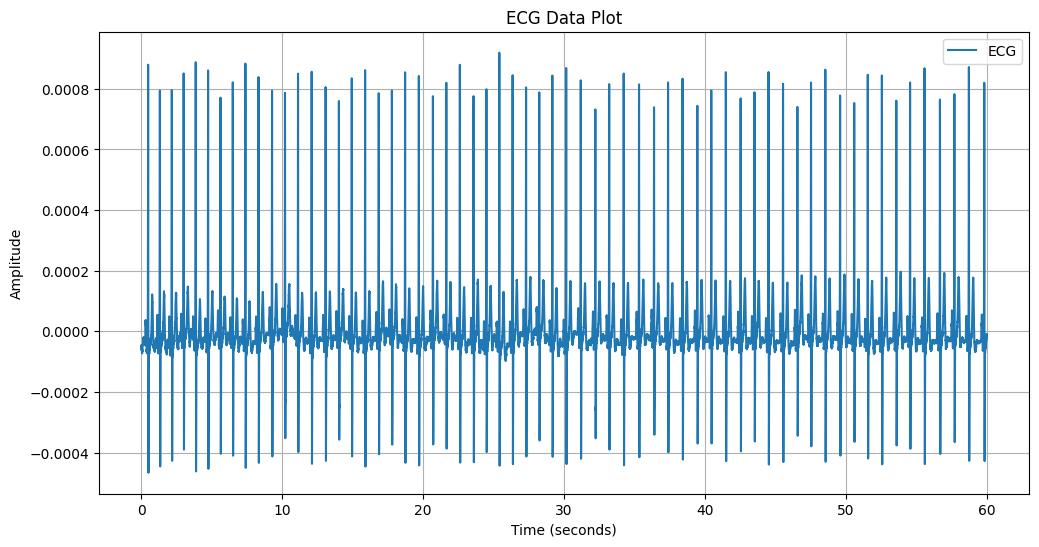

                                 ECG      Thor
Time                                          
2024-06-20 22:10:33.000000 -0.000051  0.906569
2024-06-20 22:10:33.000977 -0.000050  0.904972
2024-06-20 22:10:33.001953 -0.000049  0.903318
2024-06-20 22:10:33.002930 -0.000049  0.901616
2024-06-20 22:10:33.003906 -0.000050  0.899877
...                              ...       ...
2024-06-20 22:11:32.995117 -0.000009  0.138765
2024-06-20 22:11:32.996094 -0.000010  0.139289
2024-06-20 22:11:32.997070 -0.000012  0.139786
2024-06-20 22:11:32.998047 -0.000015  0.140255
2024-06-20 22:11:32.999023 -0.000017  0.140694

[61440 rows x 2 columns]


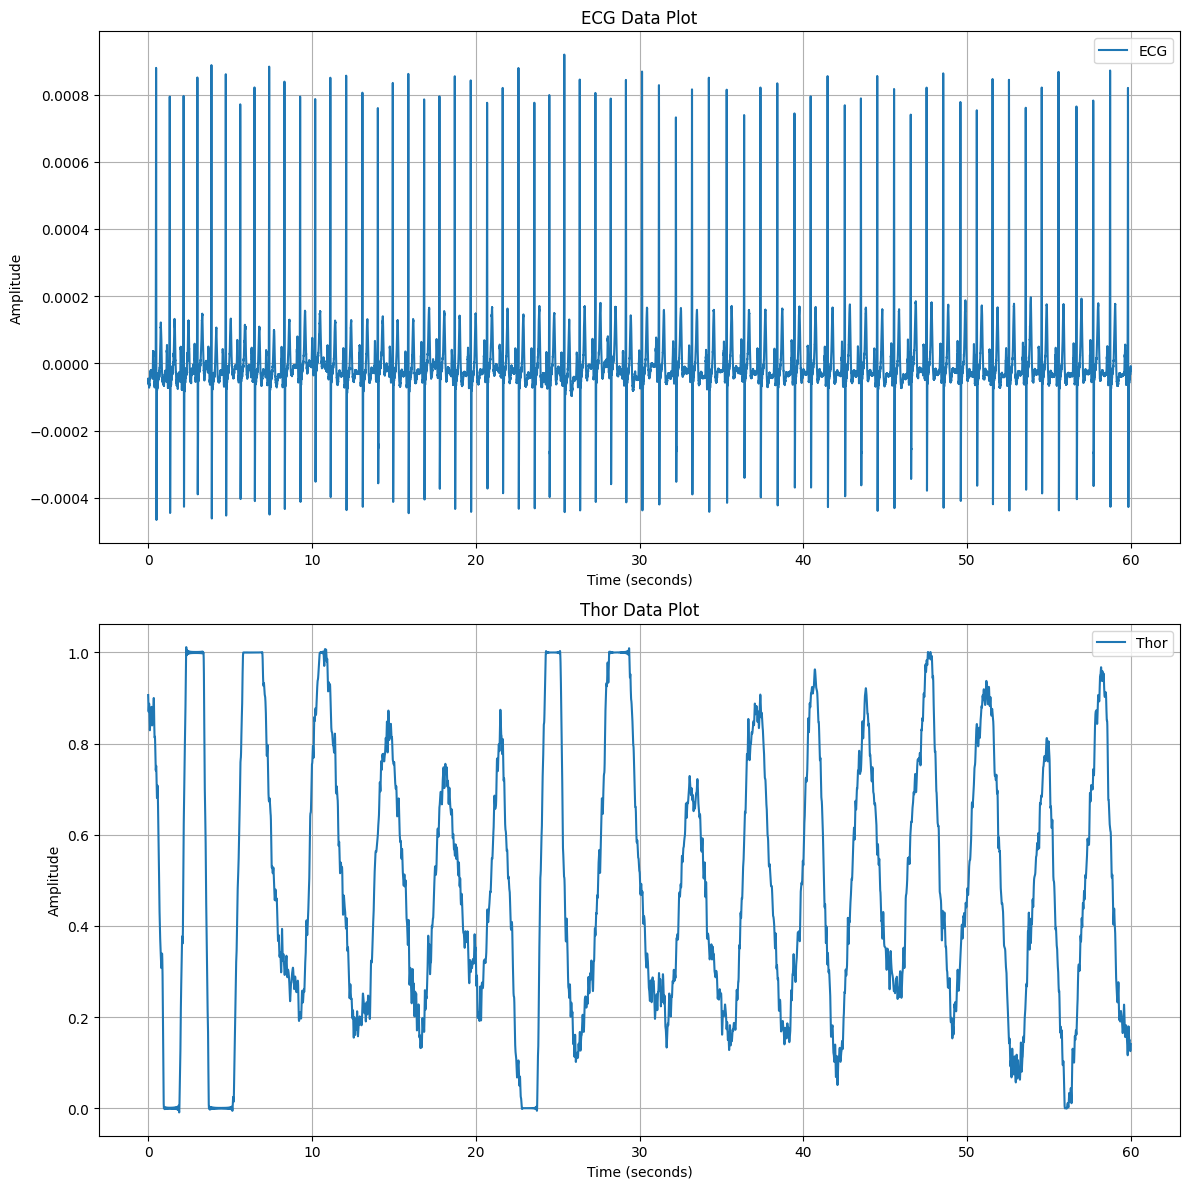

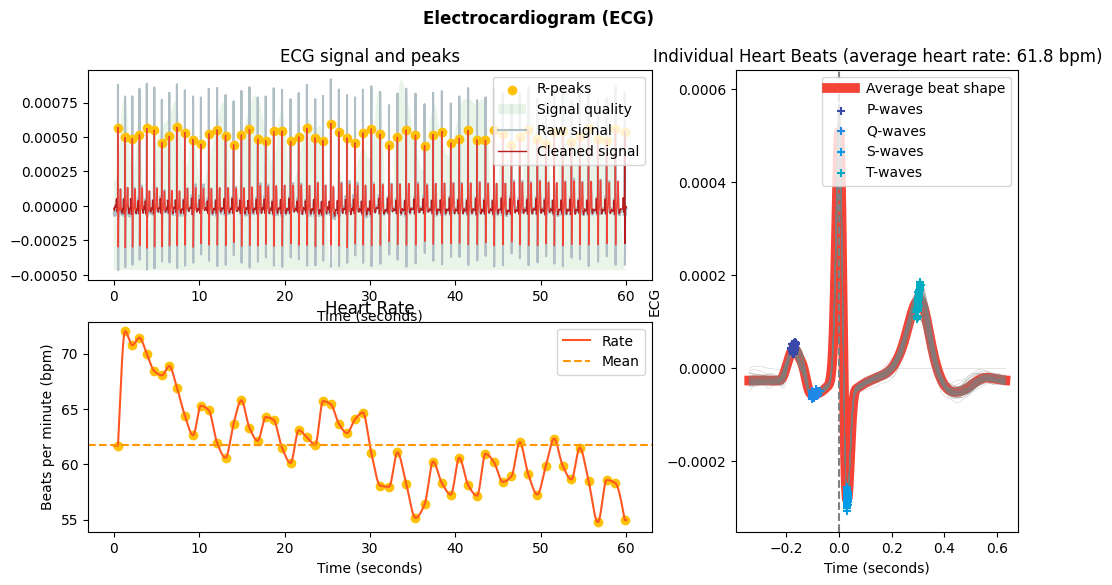

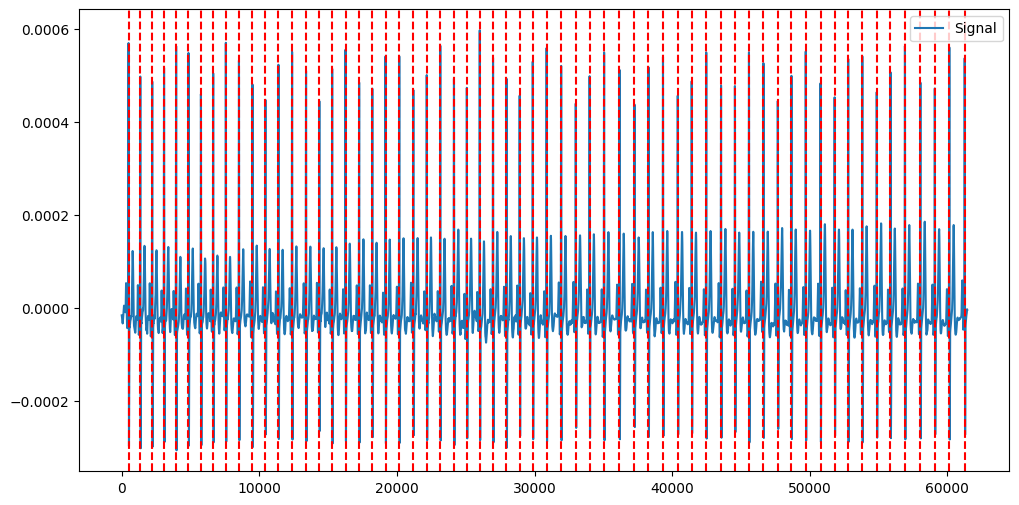

The raw signal, sampled at 1024.0 Hz, was preprocessed using a second order 0.05-3 Hz bandpass Butterworth filter.

The peak detection was carried out using the method described in Khoadadad et al. (2018).

The respiratory volume per time computation was carried out using the method described in Harrison et al. (2021).

   RSP_Rate_Mean  RSP_Rate_SD
0      16.730276      2.77315

References
- Harrison, S. J., Bianchi, S., Heinzle, J., Stephan, K. E., Iglesias, S., & Kasper, L. (2021).
            A Hilbert-based method for processing respiratory timeseries.
            Neuroimage, 230, 117787.
- Khodadad, D., Nordebo, S., Müller, B., Waldmann, A., Yerworth, R., Becher, T., ... & Bayford, R. (2018).
            Optimized breath detection algorithm in electrical impedance tomography.
            Physiological measurement, 39(9), 094001.
- Makowski, D., Pham, T., Lau, Z. J., Brammer, J. C., Lespinasse, F., Pham, H.,
    Schölzel, C., & Chen, S. A. (2021). NeuroKit2: A Python toolbox for n

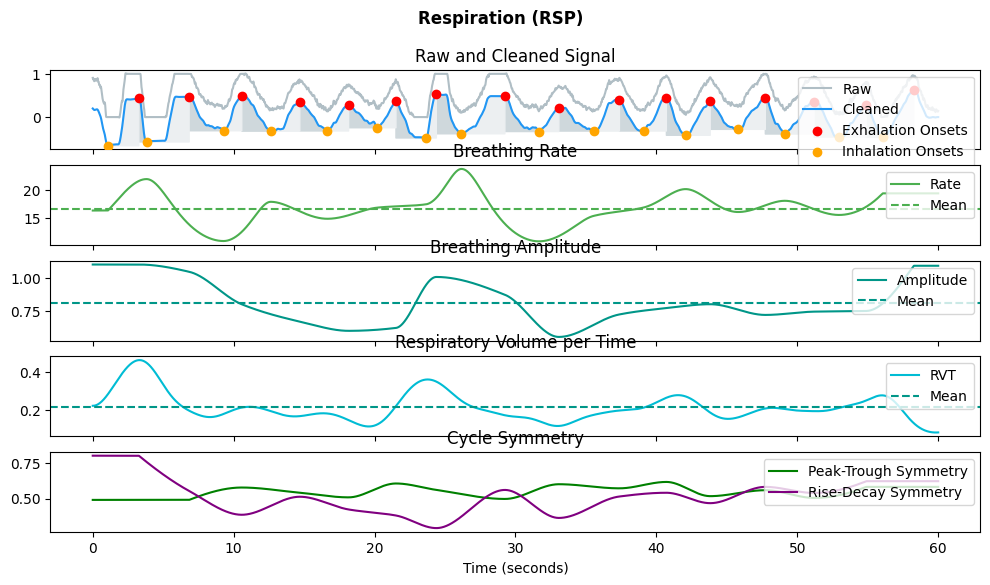

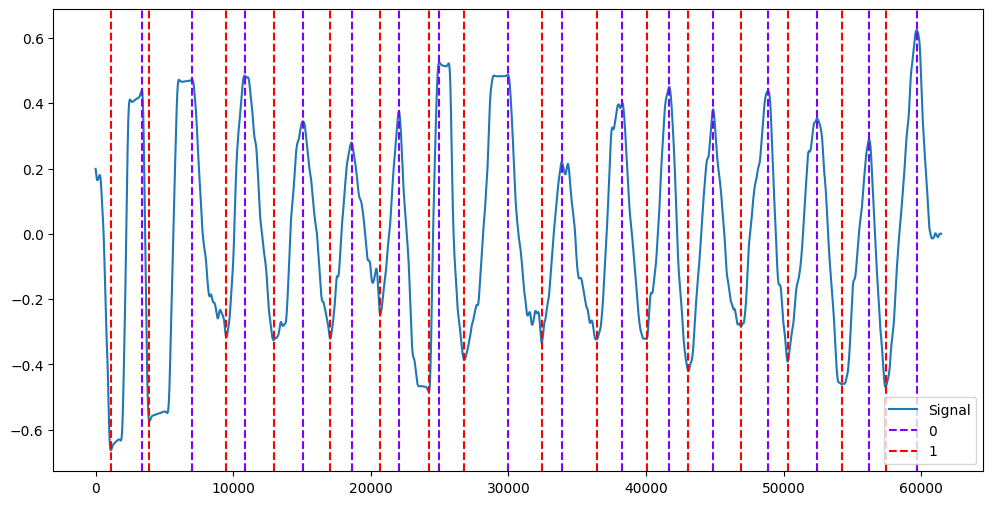

In [15]:

file_path = "/opt/data/private/ZhouWenren/SleepLab/psg/2024-6-20jiangyifan.edf"

# Create an instance of the PSGDataProcessor
psg_processor = PSGDataProcessor(file_path)

# Load the data from the specified file
psg_processor.load_data()


start_datetime = datetime(2024, 6, 20, 22, 10, 33) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 22, 11, 33)  # Replace with your actual end datetime
extracted_types = ['ECG', 'Thor']  # Replace with your actual data types

print(f"Start Timestamp: {start_datetime}, End Timestamp: {end_datetime}")  # Print the start and end timestamps of the extracted data
extracted_data = psg_processor.extract_segment_by_timestamp(start_datetime, end_datetime, extracted_types)
psg_processor.plot_data(extracted_data['ECG'], 'ECG', psg_processor.sampling_rate)
print(extracted_data)

# Plot comparison between signals
psg_processor.compare_plot(extracted_data, extracted_types, psg_processor.sampling_rate)

# Plot ECG signal
ecg_signals, ecg_info = psg_processor.ecg_diagram(extracted_data['ECG'])

# Plot RSP signal
rsp_signals, rsp_info = psg_processor.rsp_diagram(extracted_data['Thor'])
